# Arrest data v7 (prep for development)

Date: Febru 28, 2024

In [1]:
# jupyter nbconvert arrest.ipynb --to html --no-input --output=arrest-data-preview-v3.html
# inv deploy-html-notebooks --dir-name 2024-01-arrest-data

import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

import plotly
plotly.offline.init_notebook_mode()

pg_engine = create_engine("postgresql://copelco@127.0.0.1:5432/traffic_stops_nc")
pg_conn = pg_engine.connect()

In [23]:
def lookup_agencies(agency_names):
    return pd.read_sql(
        f"""
        SELECT
            id
            , name
        FROM nc_agency
        WHERE name ~ '{"|".join(agency_names)}'
        ORDER BY 2
        """,
        pg_conn,
    )
df = lookup_agencies({
    "Durham Police",
    "Raleigh Police",
    "Greensboro Police",
    "Fayetteville Police",
    'Charlotte-Mecklenburg Police',
})
agency_ids = df['id'].tolist()
df

id                                     name
0   52  Charlotte-Mecklenburg Police Department
1   80                 Durham Police Department
2   89           Fayetteville Police Department
3  105             Greensboro Police Department
4  225                Raleigh Police Department

In [3]:
from enum import Enum

class StopPurpose(Enum):
    SPEED_LIMIT_VIOLATION         = 1   # Safety Violation
    STOP_LIGHT_SIGN_VIOLATION     = 2   # Safety Violation
    DRIVING_WHILE_IMPAIRED        = 3   # Safety Violation
    SAFE_MOVEMENT_VIOLATION       = 4   # Safety Violation
    VEHICLE_EQUIPMENT_VIOLATION   = 5   # Regulatory and Equipment
    VEHICLE_REGULATORY_VIOLATION  = 6   # Regulatory and Equipment
    OTHER_MOTOR_VEHICLE_VIOLATION = 9   # Regulatory and Equipment
    SEAT_BELT_VIOLATION           = 7   # Regulatory and Equipment
    INVESTIGATION                 = 8   # Investigatory
    CHECKPOINT                    = 10  # Investigatory
    
    @classmethod
    def safety_violation(cls):
        return [cls.SPEED_LIMIT_VIOLATION.value, cls.STOP_LIGHT_SIGN_VIOLATION.value, cls.DRIVING_WHILE_IMPAIRED.value, cls.SAFE_MOVEMENT_VIOLATION.value]
    
    @classmethod
    def regulatory_equipment(cls):
        return [cls.VEHICLE_EQUIPMENT_VIOLATION.value, cls.VEHICLE_REGULATORY_VIOLATION.value, cls.OTHER_MOTOR_VEHICLE_VIOLATION.value, cls.SEAT_BELT_VIOLATION.value]
    
    @classmethod
    def investigatory(cls):
        return [cls.INVESTIGATION.value, cls.CHECKPOINT.value]

In [4]:
colors = (
     px.colors.qualitative.Pastel2[5], # Asian
     px.colors.qualitative.Pastel[9], # Black
     px.colors.qualitative.Antique[2], # Hispanic
     px.colors.qualitative.Set2[2], # Native American
     px.colors.qualitative.Set3[2], # Other
     px.colors.qualitative.Pastel[0], # White
)
color_map = {
    "Asian": px.colors.qualitative.Pastel2[5],
    "Black": px.colors.qualitative.Pastel[9],
    "Hispanic": px.colors.qualitative.Antique[2],
    "Native American": px.colors.qualitative.Set2[2],
    "Other": px.colors.qualitative.Set3[2],
    "White": px.colors.qualitative.Pastel[0],
}
pd.set_option('display.max_rows', 500)

In [5]:
stops_summary_sql = f"""
SELECT
    nc_stop.stop_id
    , date AT TIME ZONE 'America/New_York' AS stop_date
    , EXTRACT(year FROM date AT TIME ZONE 'America/New_York') AS "year"
    , nc_stop.agency_id
    , nc_stop.agency_description AS agency
    , nc_stop.officer_id
    , (CASE WHEN nc_stop.purpose = 1 THEN 'Speed Limit Violation'
            WHEN nc_stop.purpose = 2 THEN 'Stop Light/Sign Violation'
            WHEN nc_stop.purpose = 3 THEN 'Driving While Impaired'
            WHEN nc_stop.purpose = 4 THEN 'Safe Movement Violation'
            WHEN nc_stop.purpose = 5 THEN 'Vehicle Equipment Violation'
            WHEN nc_stop.purpose = 6 THEN 'Vehicle Regulatory Violation'
            WHEN nc_stop.purpose = 7 THEN 'Seat Belt Violation'
            WHEN nc_stop.purpose = 8 THEN 'Investigation'
            WHEN nc_stop.purpose = 9 THEN 'Other Motor Vehicle Violation'
            WHEN nc_stop.purpose = 10 THEN 'Checkpoint'
       END) as stop_purpose
    , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
            ELSE 'Other'
       END) as stop_purpose_group
    , (CASE WHEN nc_person.ethnicity = 'H' THEN 'Hispanic'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'A' THEN 'Asian'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'B' THEN 'Black'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'I' THEN 'Native American'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'U' THEN 'Other'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'W' THEN 'White'
       END) as driver_race
    , (CASE WHEN nc_person.gender = 'M' THEN 'male'
            WHEN nc_person.gender = 'F' THEN 'female'
       END) as driver_gender
    , (nc_search.search_id IS NOT NULL) AS driver_searched
    , driver_arrest
FROM "nc_stop"
INNER JOIN "nc_person"
    ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
LEFT OUTER JOIN "nc_search"
    ON ("nc_stop"."stop_id" = "nc_search"."stop_id")
WHERE nc_stop.agency_id IN ({",".join(map(str, agency_ids))})
"""

# 1. Percentage of Stops that led to an arrest for given racial group

In [6]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , driver_race
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count

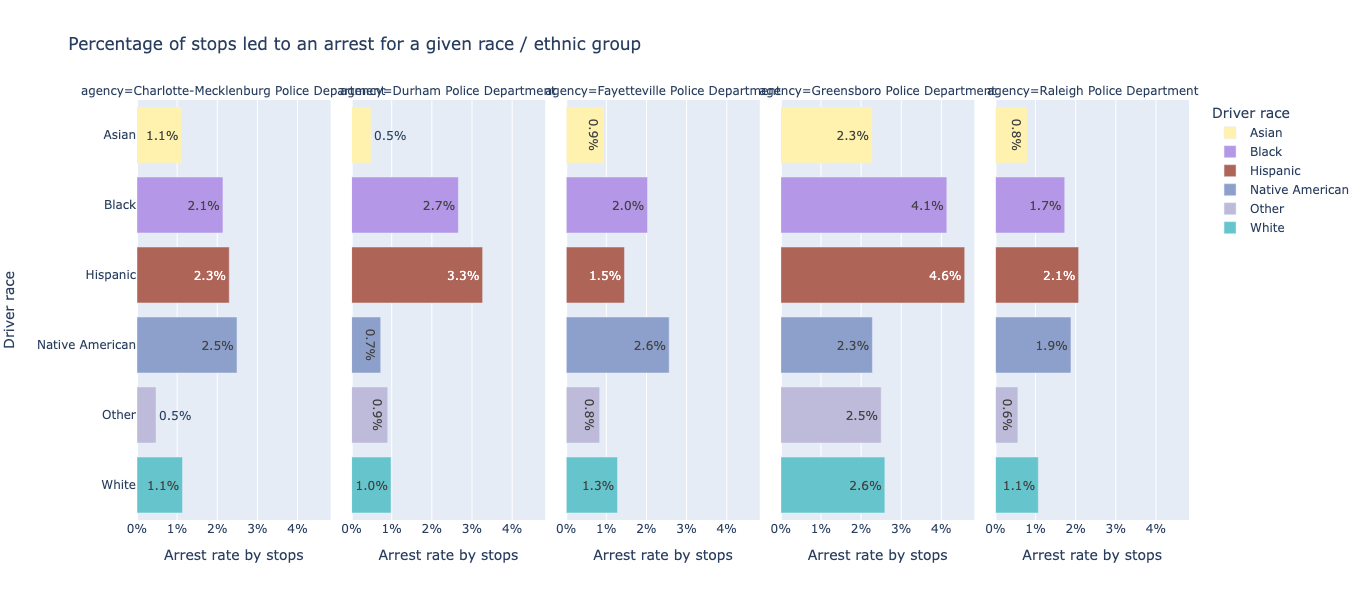

In [7]:
fig = px.bar(
    df,
    x="stop_arrest_rate",
    y="driver_race",
    color="driver_race",
    color_discrete_map=color_map,
    facet_col="agency",
    title="Percentage of stops led to an arrest for a given race / ethnic group",
    labels={
        "stop_arrest_rate": "Arrest rate by stops",
        "driver_race": "Driver race",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=600,
)
fig.update_xaxes(tickformat=",.0%")
fig

# 2. Percentage of searches that led to an arrest for given racial group

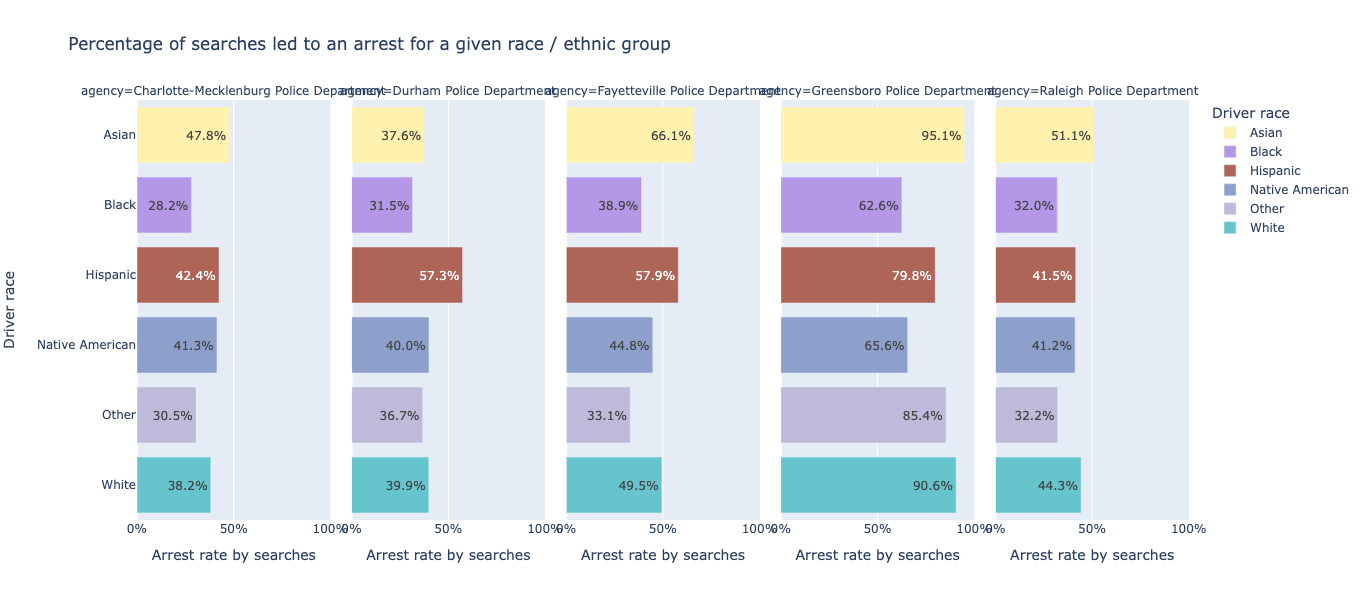

In [8]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , driver_race
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count
fig = px.bar(
    df,
    x="search_arrest_rate",
    y="driver_race",
    color="driver_race",
    color_discrete_map=color_map,
    facet_col="agency",
    title="Percentage of searches led to an arrest for a given race / ethnic group",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=600,
)
fig.update_xaxes(tickformat=",.0%")
fig

# 3. Count of stops and arrests for a given race / ethnic group

TODO: Include arrest counts within the stop counts bar (so they're not added together)

In [9]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , driver_race
        , count(*) AS Stops
        , count(*) FILTER (WHERE driver_arrest = true) AS Arrests
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)

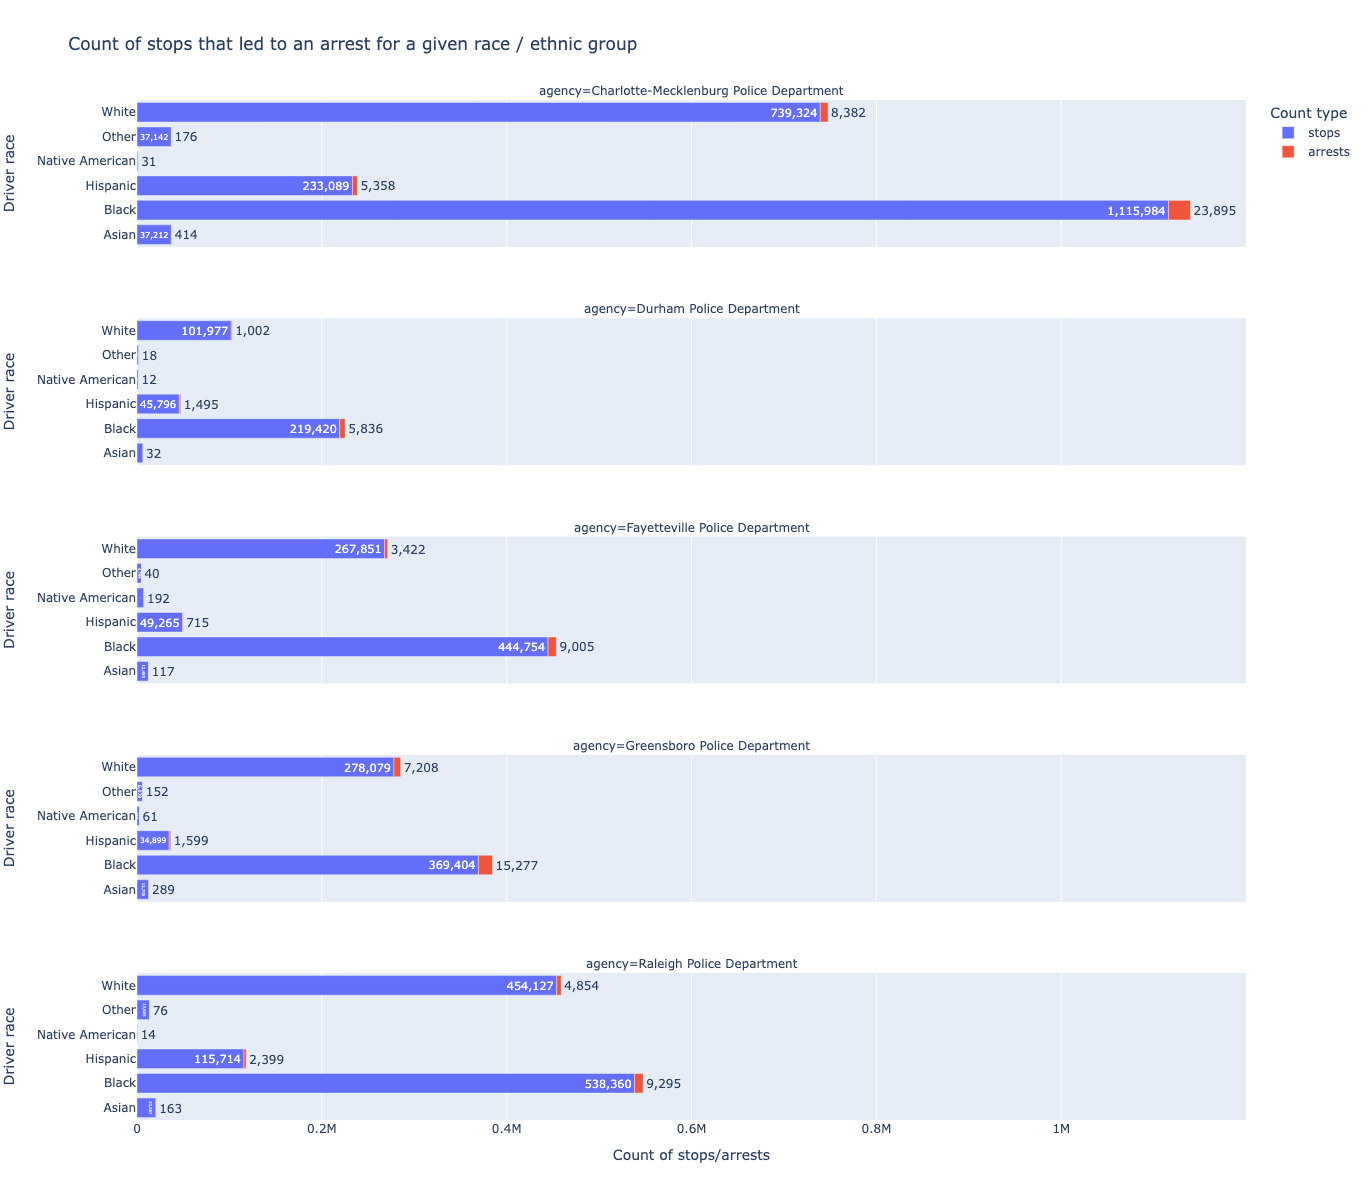

In [10]:
fig = px.bar(
    df.melt(id_vars=["agency", "driver_race"], value_vars=["stops", "arrests"], var_name="count_type", value_name="count"),
    x="count",
    y="driver_race",
    color="count_type",
    # color_discrete_map=color_map,
    facet_col="agency",
    facet_col_wrap=1,
    title="Count of stops that led to an arrest for a given race / ethnic group",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
        "count": "Count of stops/arrests",
        "count_type": "Count type",
    },
    text='count',
    text_auto=',',
    orientation='h',
    height=1200,
)
fig

In [11]:
df

agency      driver_race    stops  arrests
0   Charlotte-Mecklenburg Police Department            Asian    37212      414
1   Charlotte-Mecklenburg Police Department            Black  1115984    23895
2   Charlotte-Mecklenburg Police Department         Hispanic   233089     5358
3   Charlotte-Mecklenburg Police Department  Native American     1244       31
4   Charlotte-Mecklenburg Police Department            Other    37142      176
5   Charlotte-Mecklenburg Police Department            White   739324     8382
6                  Durham Police Department            Asian     6584       32
7                  Durham Police Department            Black   219420     5836
8                  Durham Police Department         Hispanic    45796     1495
9                  Durham Police Department  Native American     1654       12
10                 Durham Police Department            Other     2001       18
11                 Durham Police Department            White   101977     1002
12           Fayetteville Police Department            Asian    12493      117
13           Fayetteville Police Department            Black   444754     9005
14           Fayetteville Police Department         Hispanic    49265      715
15           Fayetteville Police Department  Native American     7484      192
16           Fayetteville Police Department            Other     4799       40
17           Fayetteville Police Department            White   267851     3422
18             Greensboro Police Department            Asian    12705      289
19             Greensboro Police Department            Black   369404    15277
20             Greensboro Police Department         Hispanic    34899     1599
21             Greensboro Police Department  Native American     2674       61
22             Greensboro Police Department            Other     6078      152
23             Greensboro Police Department            White   278079     7208
24                Raleigh Police Department            Asian    20567      163
25                Raleigh Police Department            Black   538360     9295
26                Raleigh Police Department         Hispanic   115714     2399
27                Raleigh Police Department  Native American      744       14
28                Raleigh Police Department            Other    13605       76
29                Raleigh Police Department            White   454127     4854

# 4a. Percentage of stops that led to arrest for given stop purpose group

TODO: Set x axis to by 0-1

In [12]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , stop_purpose_group
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count

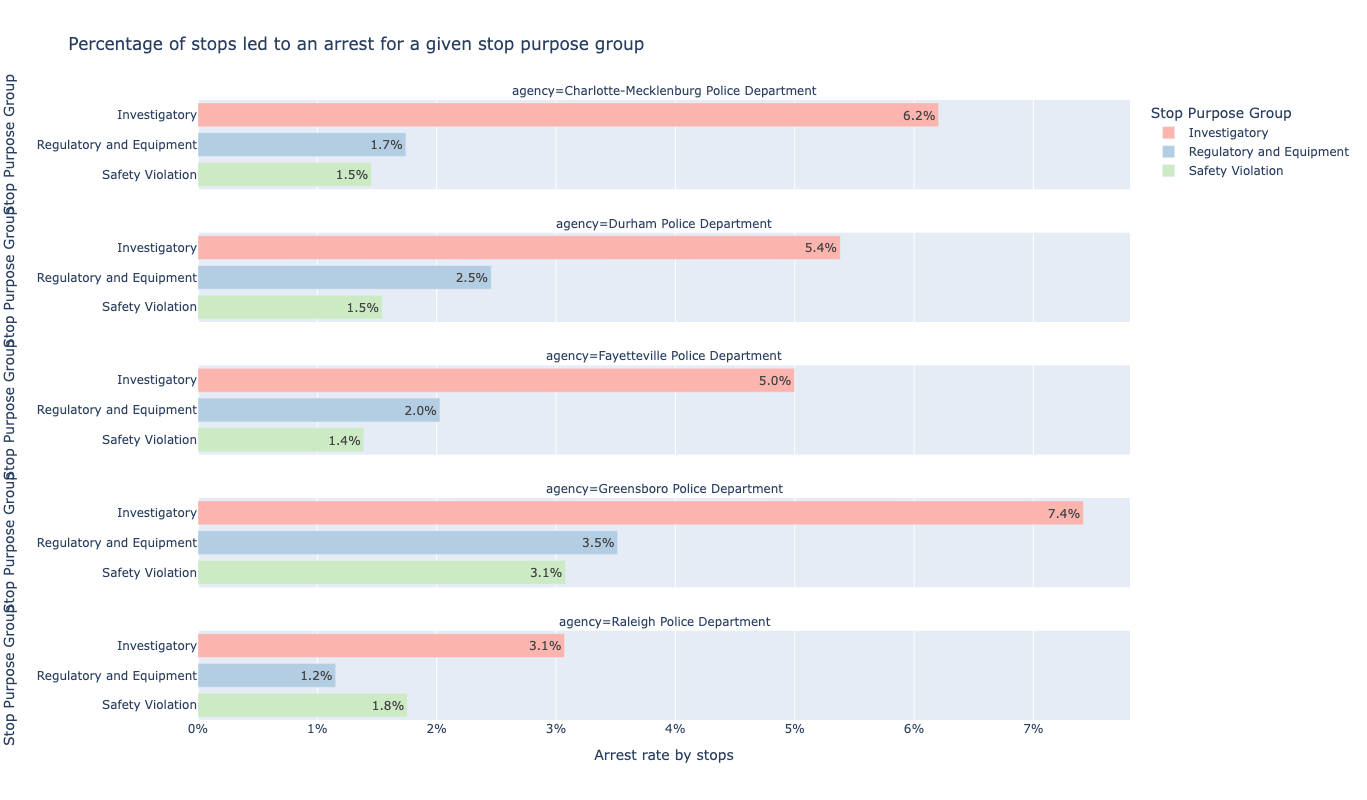

In [13]:
fig = px.bar(
    df,
    x="stop_arrest_rate",
    y="stop_purpose_group",
    color="stop_purpose_group",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    facet_col_wrap=1,
    title="Percentage of stops led to an arrest for a given stop purpose group",
    labels={
        "stop_arrest_rate": "Arrest rate by stops",
        "driver_race": "Driver race",
        "stop_purpose_group": "Stop Purpose Group",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=800,
)
fig.update_xaxes(tickformat=",.0%")
fig

# 4b. Percentage of stops that led to arrest for a given stop purpose

In [14]:
%%time

df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , stop_purpose
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count

CPU times: user 3.67 ms, sys: 847 µs, total: 4.52 ms
Wall time: 7.84 s


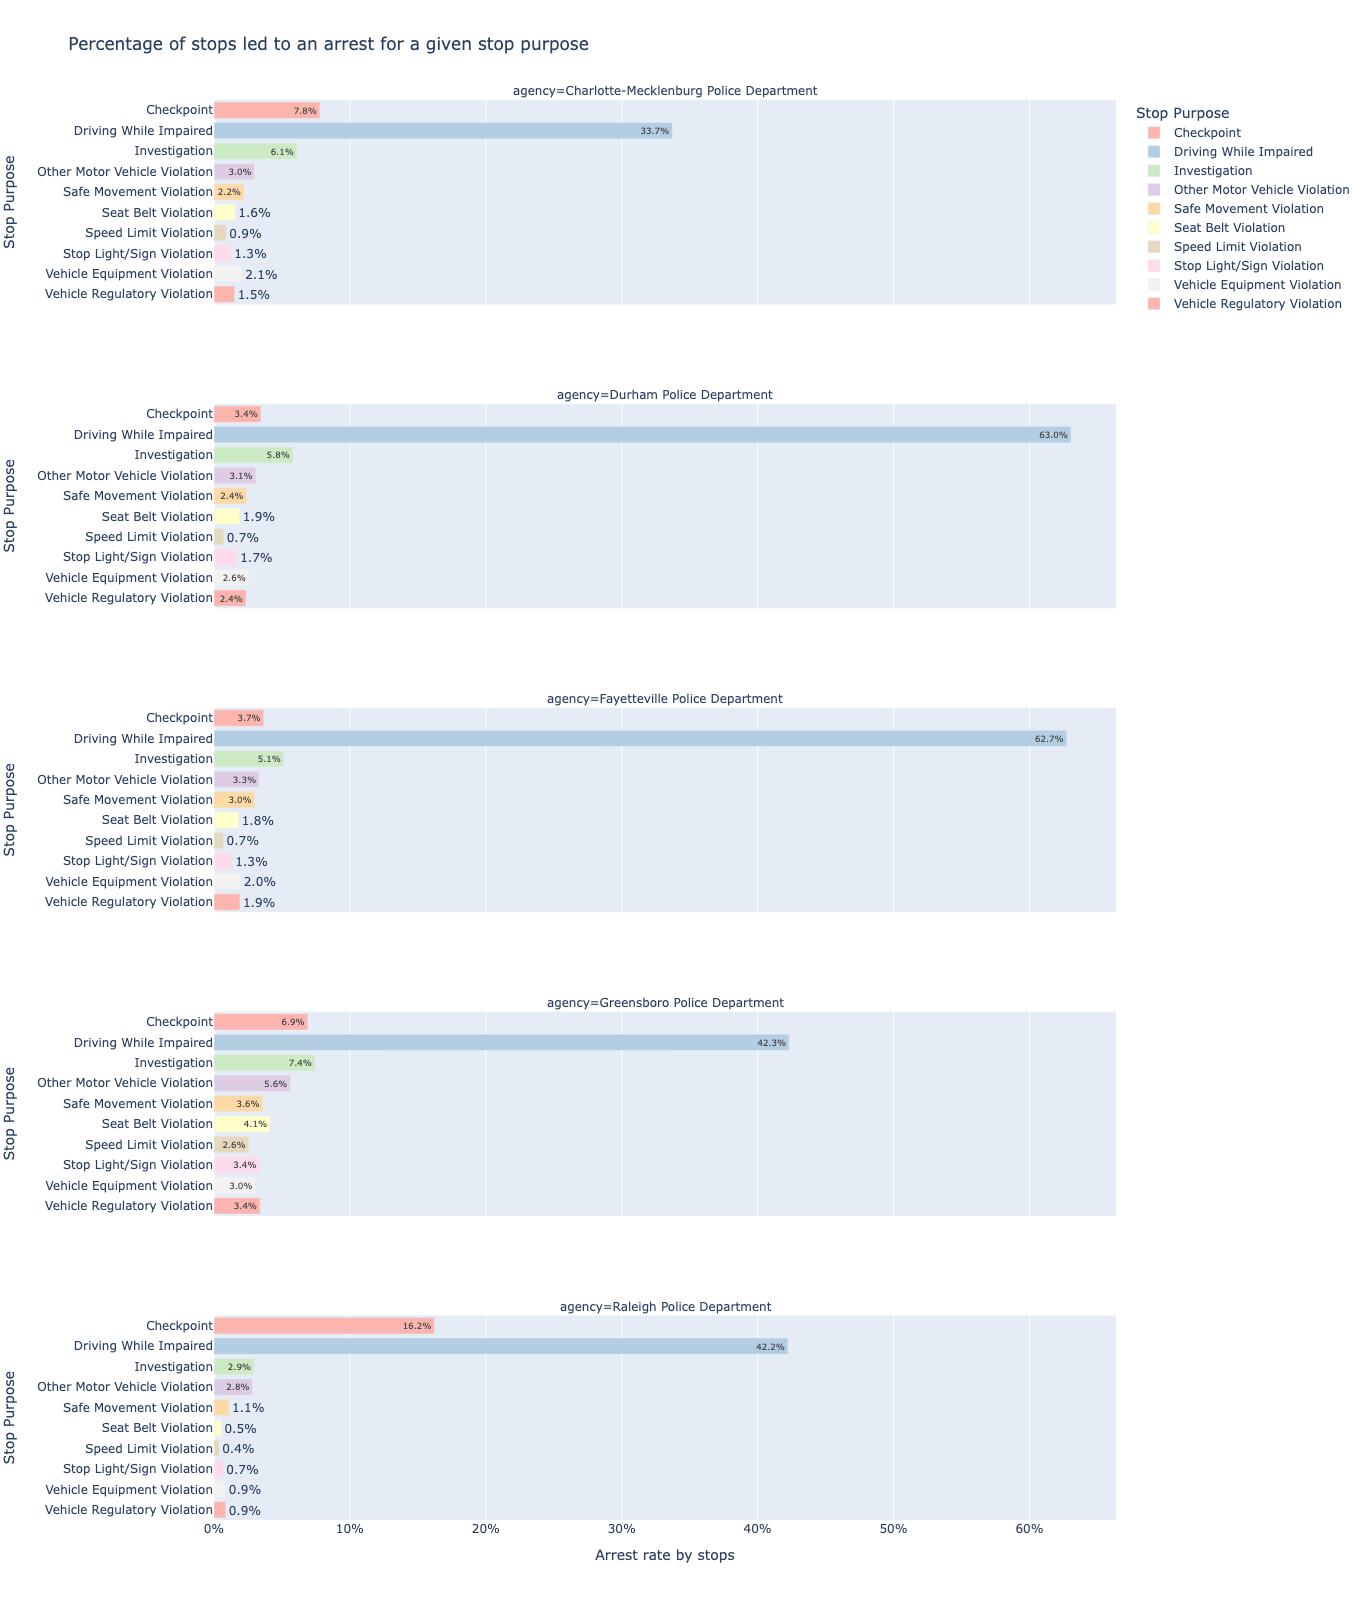

In [15]:
fig = px.bar(
    df,
    x="stop_arrest_rate",
    y="stop_purpose",
    color="stop_purpose",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    facet_col_wrap=1,
    title="Percentage of stops led to an arrest for a given stop purpose",
    labels={
        "stop_arrest_rate": "Arrest rate by stops",
        "driver_race": "Driver race",
        "stop_purpose": "Stop Purpose",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=1600,
)
fig.update_xaxes(tickformat=",.0%")
fig

# 5a. Percentage of searches that led to arrest for a given stop purpose group

In [16]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , stop_purpose_group
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count

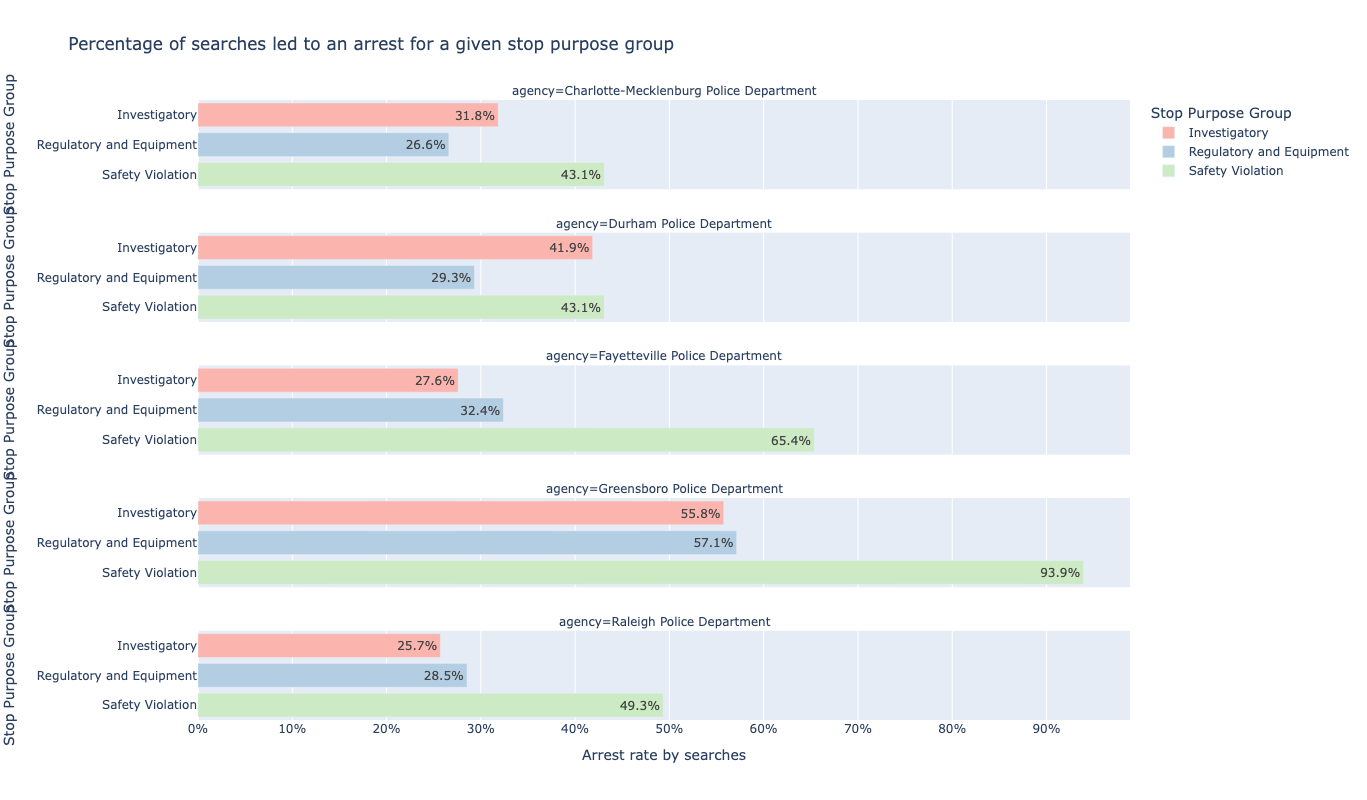

In [17]:
fig = px.bar(
    df,
    x="search_arrest_rate",
    y="stop_purpose_group",
    color="stop_purpose_group",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    facet_col_wrap=1,
    title="Percentage of searches led to an arrest for a given stop purpose group",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
        "stop_purpose_group": "Stop Purpose Group",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=800,
)
fig.update_xaxes(tickformat=",.0%")
# fig.update_yaxes(visible=False)
fig

# 5b. Percentage of searches that led to arrest for a given stop purpose

TODO: Update colors so that regulatory and checkpoint aren't so close in color

In [18]:
%%time

df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , stop_purpose
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count

CPU times: user 4.12 ms, sys: 1.49 ms, total: 5.61 ms
Wall time: 7.97 s


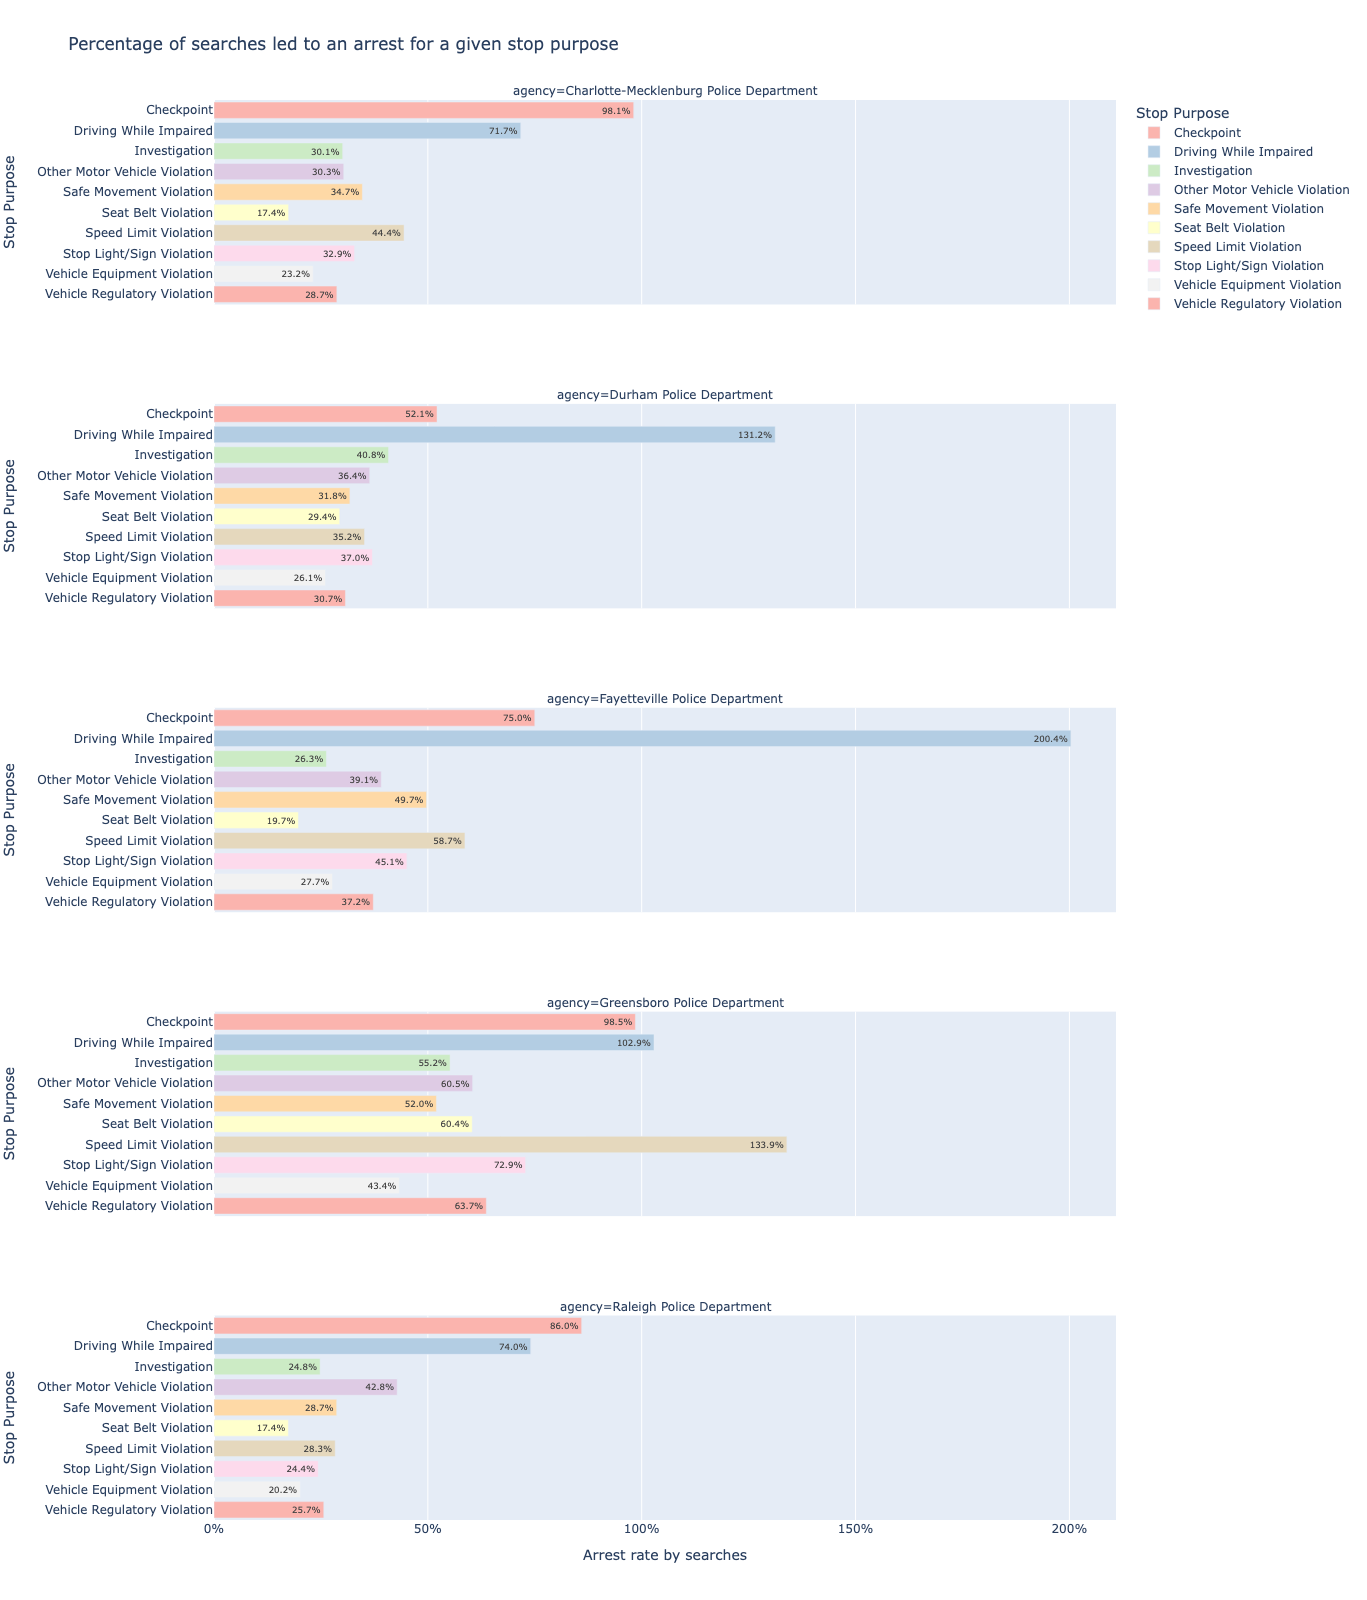

In [19]:
fig = px.bar(
    df,
    x="search_arrest_rate",
    y="stop_purpose",
    color="stop_purpose",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    facet_col_wrap=1,
    title="Percentage of searches led to an arrest for a given stop purpose",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
        "stop_purpose": "Stop Purpose",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=1600,
)
fig.update_xaxes(tickformat=",.0%")
fig

# 6. Percentage of Stops that led to arrest after a search uncovered contraband by specific contraband type

In [20]:
df = pd.read_sql(
    f"""
    WITH stops AS (
        SELECT
            agency_id
            , agency_description AS agency
            , count(*) as stop_count
            , count(DISTINCT nc_search.search_id) AS search_count
        FROM nc_stop
        LEFT OUTER JOIN nc_search ON (nc_search.stop_id = nc_stop.stop_id)
        WHERE nc_stop.agency_id IN ({",".join(map(str, agency_ids))})
        GROUP BY 1, 2
    )
    SELECT
        agency
        , contraband_type
        , stop_count AS all_stop_count
        , search_count AS all_search_count
        , count(stop_id) FILTER (WHERE contraband_found = true) AS contraband_count
        , count(stop_id) FILTER (WHERE contraband_found = true AND driver_arrest = true) AS contraband_and_driver_arrest_count
    FROM nc_contrabandsummary summary
    JOIN stops ON (stops.agency_id = summary.agency_id)
    WHERE summary.agency_id IN ({",".join(map(str, agency_ids))})
      --AND contraband_found = true
    GROUP BY 1, 2, 3, 4
    ORDER BY 1
    """,
    pg_engine,
    # dtype={"year": "Int64"}
)
df["driver_contraband_arrest_rate"] = df.contraband_and_driver_arrest_count / df.contraband_count
df["driver_stop_arrest_rate"] = df.contraband_and_driver_arrest_count / df.all_stop_count

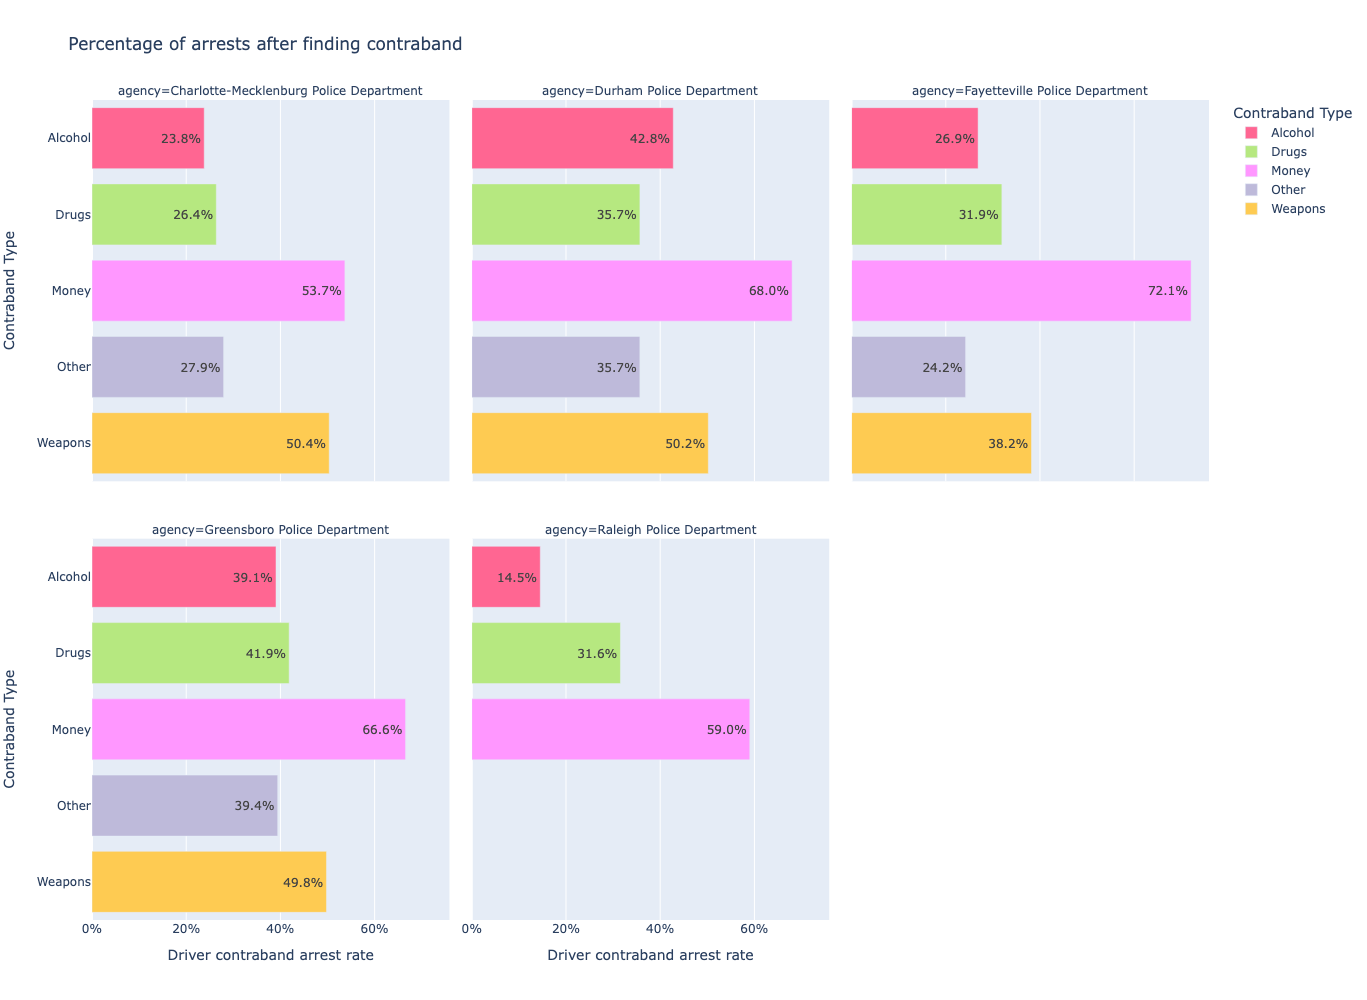

In [21]:
fig = px.bar(
    df,
    x="driver_contraband_arrest_rate",
    y="contraband_type",
    color="contraband_type",
    color_discrete_map=color_map,
    facet_col="agency",
    facet_col_wrap=3,
    title="Percentage of arrests after finding contraband",
    labels={
        "contraband_type": "Contraband Type",
        "driver_contraband_arrest_rate": "Driver contraband arrest rate",
    },
    text='driver_contraband_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=1000,
    # range_x=[0, 1],
)
fig.update_xaxes(tickformat=",.0%")
fig